# DelftaCalculator basics and $\Delta$-learning vs. direct learning 

In [1]:
import os
import glob
from openbabel.pybel import readfile, readstring
import numpy as np
from delfta.utils import TESTS_PATH, DATA_PATH

Next, we read a few example molecules from SDFs (structure data files) from the QMugs dataset. For more details on how to input your own molecules, see the documentation of the Pybel API [here](https://open-babel.readthedocs.io/en/latest/UseTheLibrary/Python_PybelAPI.html).

In [2]:
if not os.path.exists(os.path.join(TESTS_PATH)): 
    from delfta.download import TESTS_REMOTE, download
    import tarfile 
    
    download(TESTS_REMOTE, os.path.join(DATA_PATH, "test_data.tar.gz"))
    with tarfile.open(os.path.join(DATA_PATH, "test_data.tar.gz")) as handle:
        handle.extractall(DATA_PATH)

mol_files = glob.glob(os.path.join(TESTS_PATH, "mols_working", "CHEMBL*.sdf"))
mols = [next(readfile("sdf", mol_file)) for mol_file in mol_files]

We'll initialize a calculator by stating which tasks we want to perform. Options are `all` (the default), `E_form`, `E_homo`, `E_lumo`, `E_gap`, `dipole`, and `charges`. You can also choose between `delta=True` (run a GNF2-xTB calculation and predict a delta correction to obtain an approximation of the DFT-value ($\omega$B97X-D/def2-SVP)) or `delta=False` (predict the DFT-value directly from the molecular structure).

In [3]:
from delfta.calculator import DelftaCalculator

calc_delta = DelftaCalculator(tasks=["E_form", "E_homo", "E_lumo", "E_gap", "dipole", "charges"], delta=True) 
# We'll skip Wiberg bond orders in this tutorial as this requires some more verbose handling of atom/bond ids later on 
predictions_delta = calc_delta.predict(mols, batch_size=32) # lower the batch size if you run into memory issues
calc_direct = DelftaCalculator(tasks=["E_form", "E_homo", "E_lumo", "E_gap", "dipole", "charges"], delta=False) 
predictions_direct = calc_direct.predict(mols)

2021/12/08 06:05:47 PM | rdkit | INFO: Enabling RDKit 2020.09.1 jupyter extensions
2021/12/08 06:05:48 PM | DelFTa | INFO: Now running xTB...
100%|██████████| 100/100 [00:50<00:00,  2.00it/s]
2021/12/08 06:06:39 PM | DelFTa | INFO: Now running network for model single_energy_delta...
100%|██████████| 100/100 [00:17<00:00,  5.78it/s]
2021/12/08 06:06:56 PM | DelFTa | INFO: Now running network for model multitask_delta...
100%|██████████| 100/100 [00:16<00:00,  6.05it/s]
2021/12/08 06:07:13 PM | DelFTa | INFO: Now running network for model charges_delta...
100%|██████████| 100/100 [00:16<00:00,  6.12it/s]
2021/12/08 06:07:29 PM | DelFTa | INFO: Now running network for model multitask_direct...
100%|██████████| 100/100 [00:16<00:00,  6.13it/s]
2021/12/08 06:07:45 PM | DelFTa | INFO: Now running network for model single_energy_direct...
100%|██████████| 100/100 [00:16<00:00,  6.20it/s]
2021/12/08 06:08:02 PM | DelFTa | INFO: Now running network for model charges_direct...
100%|██████████| 

Let's put the output in a dataframe to get an overview: 

In [4]:
import pandas as pd

df = pd.DataFrame(predictions_delta)
df.insert(0, "structure", [os.path.basename(mol_file) for mol_file in mol_files])
df.rename(columns={"E_form": "E_form [Ha]", "E_homo": "E_homo [Ha]", "E_lumo": "E_lumo [Ha]", "E_gap": "E_gap [Ha]", "dipole": "dipole [D]", "charges": "charges [e]"})

,structure,E_form [Ha],E_homo [Ha],E_lumo [Ha],E_gap [Ha],dipole [D],charges [e]
0,CHEMBL1257920_conf_01.sdf,-12.067714,-0.271621,0.011796,0.283472,3.068150,"[-0.0167659875866127, -0.10382815221131325, 0...."
1,CHEMBL378974_conf_01.sdf,-9.294336,-0.287008,-0.014080,0.272943,4.979666,"[0.11417336181800843, -0.06804041017242432, -0..."
2,CHEMBL2435942_conf_01.sdf,-10.153416,-0.323262,0.008217,0.331456,6.196690,"[-0.26796647732948303, 0.26654998563334464, -0..."
3,CHEMBL344765_conf_01.sdf,-10.014400,-0.282950,0.021040,0.303984,3.041158,"[0.13832196788511275, -0.32947154990781785, 0...."
4,CHEMBL1927423_conf_00.sdf,-5.891820,-0.275376,0.029723,0.305043,4.827776,"[-0.0771325201799774, 0.16096720328565597, -0...."
...,...,...,...,...,...,...,...
95,CHEMBL498248_conf_02.sdf,-7.161572,-0.308261,-0.056685,0.251593,2.842437,"[0.1616166007135582, -0.4129951246446991, 0.19..."
96,CHEMBL278994_conf_00.sdf,-11.061175,-0.282417,0.028006,0.310412,3.643762,"[-0.04754336563816071, -0.06284205383376598, 0..."
97,CHEMBL2042151_conf_02.sdf,-9.881598,-0.279254,0.024066,0.303363,6.819334,"[0.05259309636276245, -0.05233039343358993, -0..."
98,CHEMBL3617648_conf_01.sdf,-8.216005,-0.309600,-0.005042,0.304597,3.374167,"[0.01838830315170288, -0.014452326382102965, 0..."


Get the DFT-calculated values from the QMugs SDFs and prepare everything for plotting:

In [5]:
predictions_delta["charges"] = np.concatenate(predictions_delta["charges"])
predictions_direct["charges"] = np.concatenate(predictions_direct["charges"])
dft_keys = ["DFT:FORMATION_ENERGY", "DFT:HOMO_ENERGY", "DFT:LUMO_ENERGY", "DFT:HOMO_LUMO_GAP", "DFT:DIPOLE", "DFT:MULLIKEN_CHARGES"]
dft_values = {}
for dft_key in dft_keys:
    if dft_key == "DFT:DIPOLE": 
        dft_values[dft_key] =  [float(mol.data[dft_key].split("|")[-1]) for mol in mols]
    elif dft_key == "DFT:MULLIKEN_CHARGES": 
        dft_values[dft_key] = [float(elem) for mol in mols for elem in mol.data[dft_key].split("|")]
    else:
        dft_values[dft_key] = [float(mol.data[dft_key]) for mol in mols]



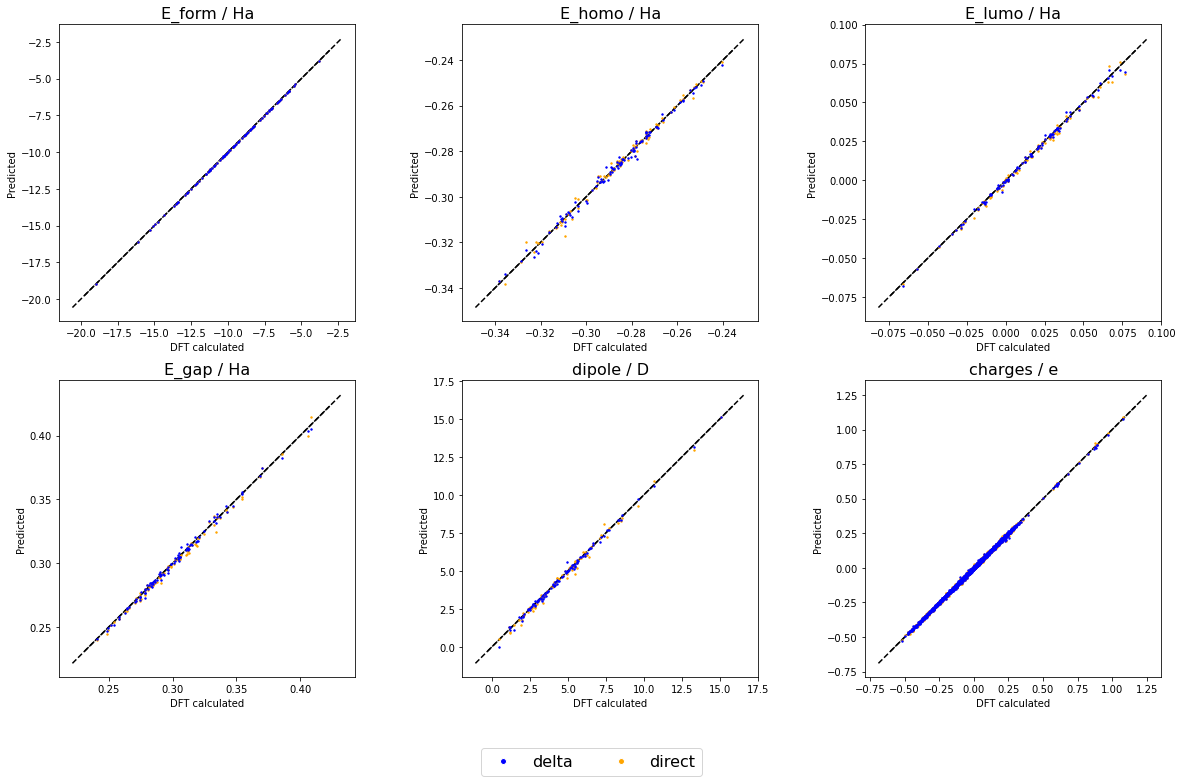

In [6]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

def make_plot(ax, dft_vals, pred_vals, color): 
    ax.scatter(dft_vals, pred_vals, color=color, s=2)
    ax.set_xlabel("DFT calculated")
    ax.set_ylabel("Predicted")
    min_val = [min(ax.get_ylim()[0], ax.get_xlim()[0])]
    max_val = [max(ax.get_ylim()[1], ax.get_xlim()[1])]
    ax.plot([min_val, max_val], [min_val, max_val], '--', color="black", zorder=-1)
    ax.set_aspect("equal", "box")

fig = plt.figure(figsize=(20, 12))
gs = GridSpec(nrows=2, ncols=3)
gs.update(wspace=0.3, hspace=0.2)
pred_keys = ["E_form", "E_homo", "E_lumo", "E_gap", "dipole", "charges"]
all_dft_vals = [dft_values[dft_key] for dft_key in dft_keys]
all_pred_vals_delta = [predictions_delta[pred_key] for pred_key in pred_keys]
all_pred_vals_direct = [predictions_direct[pred_key] for pred_key in pred_keys]
units = ["Ha", "Ha", "Ha", "Ha", "D", "e"]
axes = [fig.add_subplot(gs[i,j]) for i in range(2) for j in range(3)]
for ax, pred_key, dft_key, unit in zip(axes, pred_keys, dft_keys, units): 
    make_plot(ax, dft_values[dft_key], predictions_direct[pred_key], "orange")
    make_plot(ax, dft_values[dft_key], predictions_delta[pred_key], "blue")
    ax.title.set_text(f"{pred_key} / {unit}")
    ax.title.set_fontsize(16)

handles = [Line2D([0], [0], marker='o', color="white", markerfacecolor="blue"), Line2D([0], [0], marker='o', color="white", markerfacecolor="orange")]
fig.legend(handles, ["delta", "direct"], fontsize=16, loc="lower center", ncol=2)

As you can see, both $\Delta$- and direct-learning approximate the $\omega$B97X-D/def2-SVP ground truth well. Check our paper for a more detailed discussion.

You can also create molecules directly from SMILES. In that case, you need to keep `force3D=True` (the default), so that the Pybel generates a three-dimensional structure for the molecule using the MMFF94 force field. Alternatively, you can create three-dimensional coordinates in some other way and feed the molecule to the calculator afterwards.

In [7]:
mols = [readstring("smi", "O=C(C)Oc1ccccc1C(=O)O")] # aspirin
calc = DelftaCalculator(delta=True, force3d=True)
preds_delta = calc.predict(mols)
print(preds_delta)

2021/12/08 06:08:20 PM | DelFTa | INFO: Assigned MMFF94 coordinates and added hydrogens to molecules at position(s) [0]
2021/12/08 06:08:20 PM | DelFTa | INFO: Now running xTB...
100%|██████████| 1/1 [00:00<00:00,  7.91it/s]
2021/12/08 06:08:20 PM | DelFTa | INFO: Now running network for model single_energy_delta...
100%|██████████| 1/1 [00:00<00:00, 35.96it/s]
2021/12/08 06:08:21 PM | DelFTa | INFO: Now running network for model wbo_delta...
100%|██████████| 1/1 [00:00<00:00, 41.22it/s]
2021/12/08 06:08:21 PM | DelFTa | INFO: Now running network for model multitask_delta...
100%|██████████| 1/1 [00:00<00:00, 36.58it/s]
2021/12/08 06:08:21 PM | DelFTa | INFO: Now running network for model charges_delta...
100%|██████████| 1/1 [00:00<00:00, 36.31it/s]

{'E_form': array([-3.8746886], dtype=float32), 'wbo': [{'0-1': 2.292176887011695, '0-3': 0.15058485562021587, '1-2': 1.061614620423095, '1-3': 1.2591233179104853, '2-13': 0.9277594698289024, '2-14': 0.9439200013395926, '2-15': 0.9477035651011128, '3-4': 1.1707922241362336, '4-5': 1.4190171243558203, '4-9': 1.3646148657938326, '5-6': 1.4699672499932686, '5-8': 0.11251896210523665, '5-16': 0.9265357501999056, '6-7': 1.451472638041616, '6-17': 0.9310086284790151, '7-8': 1.4757284823664998, '7-18': 0.931844918689183, '8-9': 1.3926237308755018, '8-19': 0.9218450903020963, '9-10': 1.0407040480093444, '10-11': 2.1922851123952487, '10-12': 1.3605996444455215, '11-12': 0.16704376285474426, '12-20': 1.0672468446154997}], 'E_homo': array([-0.34341407], dtype=float32), 'E_lumo': array([-0.01132253], dtype=float32), 'E_gap': array([0.33211848], dtype=float32), 'dipole': array([3.6191292], dtype=float32), 'charges': [array([-0.19506211,  0.18483066, -0.09278427, -0.29191027,  0.20933224,
       -0.0